In [1]:
import scipy
from scipy.interpolate import CubicSpline as CubicSpline
from scipy.interpolate import interp1d as interp1d
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
data= pd.read_excel('bitcoin-excel.xlsx')
data= data.drop(data.columns[2], axis=1)
data.columns=['date','price', 'volume', 'capitalization']
data

,date,price,volume,capitalization
0,11:40,65469.710503,2.593995e+10,1.235658e+12
1,14.11.2021,64099.343163,2.448032e+10,1.209765e+12
2,13.11.2021,64264.021087,3.012345e+10,1.212811e+12
3,12.11.2021,63963.062127,3.841273e+10,1.207071e+12
4,11.11.2021,65003.739331,4.333480e+10,1.226653e+12
...,...,...,...,...
2141,05.01.2016,431.960000,3.452260e+07,6.500393e+09
2142,04.01.2016,433.090000,3.847750e+07,6.515713e+09
2143,03.01.2016,430.010000,3.963380e+07,6.467430e+09
2144,02.01.2016,433.440000,3.009660e+07,6.517390e+09


In [3]:
#выбрасываем первую строчку и меняем индекс
data=data.drop(0)
data=data.reset_index(drop=True)

In [4]:
# Преобразуем в формат времени
data['date']= pd.to_datetime(data['date'], format='%d.%m.%Y')

In [5]:
# period_num=20
date='01.01.2019'
df=data[data['date']>pd.to_datetime(date, format='%d.%m.%Y')].copy()
# Обрезаем данные
# df=df[3:]
# Прореживаем данные
df=df[::3] # Берем каждый 7 день
df=df.sort_values(by='date')
df=df.reset_index(drop=True)
# df['value']=df['value'].apply(lambda x: x/df.iloc[period_num].value) # Нормализуем данные по нужному периоду
# df.iloc[period_num]['date']
df

,date,price,volume,capitalization
0,2019-01-02,3943.410000,5.244857e+09,6.884986e+10
1,2019-01-05,3845.190000,5.137610e+09,6.715757e+10
2,2019-01-08,4030.850000,5.306593e+09,7.042274e+10
3,2019-01-11,3687.370000,5.538713e+09,6.444330e+10
4,2019-01-14,3706.050000,5.651384e+09,6.478962e+10
...,...,...,...,...
345,2021-11-02,63142.585846,3.665817e+10,1.190990e+12
346,2021-11-05,61050.281181,3.087027e+10,1.151702e+12
347,2021-11-08,65952.274632,3.792650e+10,1.244364e+12
348,2021-11-11,65003.739331,4.333480e+10,1.226653e+12


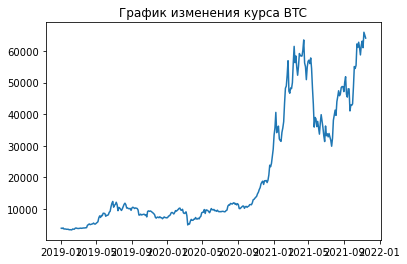

In [6]:
test_df=df.copy()
plt.plot(test_df['date'], test_df['price'])
plt.title('График изменения курса BTC');

In [7]:
from scipy.interpolate import interp1d

In [8]:
x=test_df.index.to_series()+1
y=test_df['price']
data_length=test_df.shape[0]

In [9]:
y=y/1000

In [10]:
# # Вводим вместо y разницу между ними
# x=x[1:]
# y=np.diff(y)

In [11]:
step=.05
xx = np.arange(1, data_length+step, step=step)
# xx = np.linspace(x.min(), x.max(), num=round(data_length/step), endpoint=True)
spline = CubicSpline(x, y, bc_type='clamped')
yy=spline(xx)
ww=np.diff(yy)

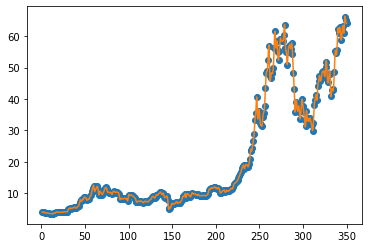

In [12]:
plt.plot(x,y,'o', xx,yy)

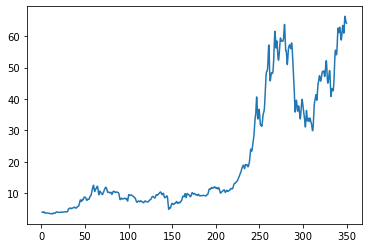

In [13]:
plt.plot(xx,yy)

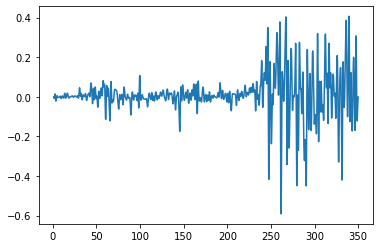

In [14]:
plt.plot(xx[1:],ww)

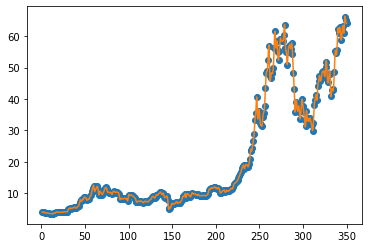

In [15]:
period_start=0
period_end=x.shape[0]
period_step=round(xx.shape[0]/x.shape[0])
plt.plot(x[period_start:period_end],y[period_start:period_end],'o', xx[period_start*period_step:period_end*period_step],yy[period_start*period_step:period_end*period_step])

In [16]:
# Находим производные сплайна порядка 0-3
pp=[]
for i in range(4):
    pp.append(spline.derivative(i))

In [17]:
# Вычисляем значения для производных сплайна
ppf=[]
for i in range(4):
    ppf.append(pp[i](xx))

In [18]:
# Задаем интервалы для интерполяции
t=np.arange(1, ppf[0].shape[0]+1)
pp1f_y=np.arange(1, ppf[0].shape[0]+.01, step=.01)

In [19]:
# Производим интерполяцию
interp1=lambda x: interp1d(t, x, kind='cubic', fill_value="extrapolate")(pp1f_y) # нужен ли параметр fill_value
deriv=[]
for i in range(4):
    deriv.append(interp1(ppf[i]))
func=deriv[0]

In [20]:
def get_ticks(arr, num=5):
    assert num>2
    
    if type(arr)==pd.core.frame.DataFrame or type(arr)==pd.core.series.Series:
        mask=np.linspace(arr.index.min(), arr.shape[0]-1, num=num).round().astype(int)
        return [arr.iloc[i] for i in mask]
    else:
        mask=np.linspace(0, arr.shape[0]-1, num=num).round().astype(int)
        return [arr[i] for i in mask]

In [21]:
step=.0005
# tt = np.linspace(0, x.max(), num=np.floor(data_length/step), endpoint=True)
tt = np.arange(1, data_length+step, step=step)

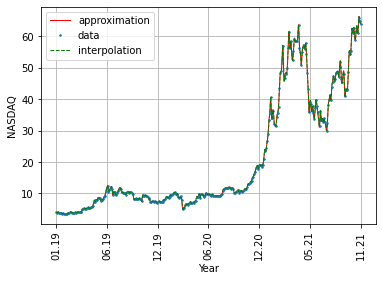

In [22]:
plt.plot(xx, ppf[0], 'r', x, y, 'o', tt, deriv[0],'--g', markersize=1.5, linewidth=1)
plt.grid()
plt.legend(['approximation', 'data', 'interpolation'], loc='best')
plt.xticks(ticks=get_ticks(xx,7), labels=map(lambda x: x.strftime('%m.%y'), get_ticks(test_df['date'],7)), rotation=90)
plt.xlabel('Year');
plt.ylabel('NASDAQ');

In [23]:
from matplotlib import cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.collections import LineCollection

In [24]:
data_step=round(tt.shape[0]/x.shape[0])

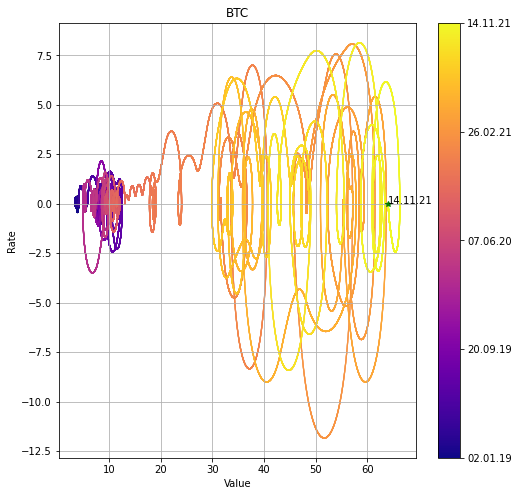

In [25]:
cmap = plt.cm.plasma
norm = plt.Normalize(x.min(), x.max())

c_bar=plt.cm.plasma(np.linspace(0, 1, tt.shape[0]))

fig, ax = plt.subplots()
ax.scatter(func, deriv[1], c=c_bar, s=0.05)
cax=ax.plot(func[-1], deriv[1][-1], '*g', markersize=6)
ax.annotate(test_df['date'].iloc[-1].strftime('%d.%m.%y'),  xy=(func[-1], deriv[1][-1]), color='black')
ax.set_ylabel('Rate')
ax.set_xlabel('Value')

plt.title('BTC')

fig.set_figheight(8)
fig.set_figwidth(8)

# fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
#              cax=cax, orientation='vertical')
# fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ticks=years, orientation='vertical')
ticks_num=5
cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ticks=get_ticks(xx, ticks_num), orientation='vertical')
cbar.ax.set_yticklabels(map(lambda x: x.strftime('%d.%m.%y'), get_ticks(test_df['date'], ticks_num)))

plt.grid()
# plt.show()
# plt.savefig(f"BTC_to_{df['date'].iloc[-1].strftime('%d_%m_%y')}.png", dpi=200)

In [28]:
def plot_phase(x, xx, tt, deriv, dates, ticks_num=5):
    func = deriv[0]
    cmap = plt.cm.plasma
    norm = plt.Normalize(x.min(), x.max())

    c_bar = plt.cm.plasma(np.linspace(0, 1, tt.shape[0]))

    fig, ax = plt.subplots()
    ax.scatter(func, deriv[1], c=c_bar, s=0.05) 
    cax = ax.plot(func[-1], deriv[1][-1], '*g', markersize=6)
    ax.annotate(dates.iloc[-1].strftime('%d.%m.%y'),  xy=(func[-1], deriv[1][-1]), color='black')
    ax.set_ylabel('Rate')
    ax.set_xlabel('Value')

    plt.title('BTC')

    fig.set_figheight(8)
    fig.set_figwidth(8)

    cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ticks=get_ticks(xx, ticks_num), orientation='vertical')
    cbar.ax.set_yticklabels(map(lambda x: x.strftime('%d.%m.%y'), get_ticks(dates, ticks_num)))

    plt.grid()
    plt.show()

In [35]:
date_start='01.01.2021'
idx_start = test_df['date'][test_df['date']>pd.to_datetime(date_start, format='%d.%m.%Y')].index.min()
slice_idx= idx_start*round(tt.shape[0]/x.shape[0])

In [29]:
def cut_plot_phase(x, xx, tt, deriv, dates, ticks_num=5, idx_start=0):
    x = x[idx_start:]
    dates = dates[idx_start:]
    
    slice_idx_xx = idx_start*round(xx.shape[0]/x.shape[0])
    
    lice_idx = idx_start*round(tt.shape[0]/x.shape[0])
    tt = tt[slice_idx:]
    deriv = [element[slice_idx:] for element in deriv]
        
    print('slice_idx: ', slice_idx)
    print(len(deriv))
    
    plot_phase(x, xx[slice_idx_xx:], tt, deriv, dates[idx_start:], ticks_num=ticks_num)

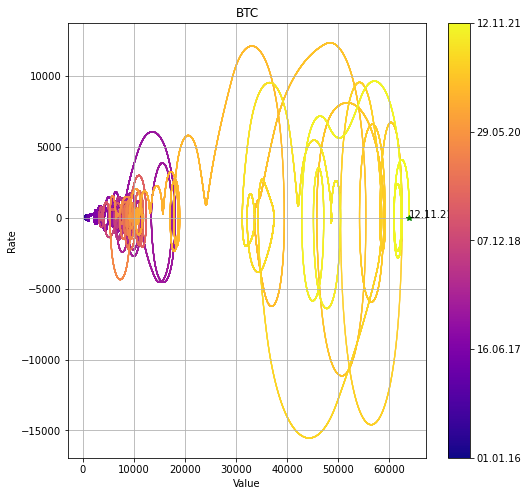

In [37]:
plot_phase(x, xx, tt, deriv, test_df['date'], ticks_num=5)

In [33]:
date_start='01.01.2021'
idx_start = test_df['date'][test_df['date']>pd.to_datetime(date_start, format='%d.%m.%Y')].index.min()

slice_idx:  486536
4


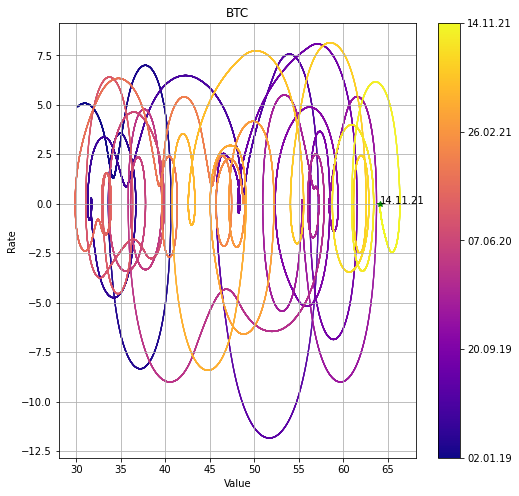

In [36]:
cut_plot_phase(x, xx, tt, deriv, test_df['date'], ticks_num=5)